In [1]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
orgs_sample = pd.read_csv("../output/complete_organizations_table.csv",index_col=0).sample(10)
inds_sample = pd.read_csv("../output/complete_individuals_table.csv",index_col=0, low_memory=False).sample(10)

In [3]:
data = {'id':['50c7d9a1-b448-46a5-8e2d-cd15b3097360','50c7d9a1-b448-46a5-8e2d-cd15b3097360','50c7d9a1-b448-46a5-8e2d-cd15b3097360',
              '62ea1e9c-ac12-400c-b3dc-519389c0f7d3','62ea1e9c-ac12-400c-b3dc-519389c0f7d3','62ea1e9c-ac12-400c-b3dc-519389c0f7d3',
              'd31df1ca-714e-4a82-9e88-1892c0451a71','d31df1ca-714e-4a82-9e88-1892c0451a71','62ea1e9c-ac12-400c-b3dc-519389c0f7d3',
              '4db76e6e-f0d5-40eb-82de-6dbcdb562dd7','f71341d7-d27e-47eb-9b66-903af39d6cb5','c875d7de-94be-42f1-b994-dd89b114d51e',
              '910c4d36-b036-469e-aa2a-ea4ff8855a6c','60d454d1-3773-4d88-80e9-132c161da0f0','1d2b5bc0-9385-4cd7-ac48-df43b3eca6fd',
              '1d2b5bc0-9385-4cd7-ac48-df43b3eca6fd','1d2b5bc0-9385-4cd7-ac48-df43b3eca6fe','1d2b5bc0-9385-4cd7-ac48-df43b3eca6ff',
              '1d2b5bc0-9385-4cd7-ac48-df43b3eca6fd'],
        'name':['REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN PAC','REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN PAC',
                'REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN PAC','UNITED FOOD AND COMMERCIAL WORKERS ACTIVE BALLOT CLUB',
                'UNITED FOOD AND COMMERCIAL WORKERS ACTIVE BALLOT CLUB','UNITED FOOD AND COMMERCIAL WORKERS ACTIVE BALLOT CLUB',
                'COMMITTEE TO ELECT DR PATRICIA BERNARD','COMMITTEE TO ELECT DR PATRICIA BERNARD','UNITED FOOD AND COMMERCIAL WORKERS ACTIVE BALLOT CLUB',
                'Ugi Utilities Inc/Ugi Energy Services Llc Pac','Pabar Pac (Pa Bar Assn)','Pa Fraternal Order Of Police Pac','Citizens For Kail',
                'Paa Pac','MICHIGAN ASSOCIATION OF NURSE ANESTHETISTS PAC','MICHIGAN ASSOCIATION OF NURSE ANESTHETISTS PAC',
                'MICHIGAN ASSOCIATION OF NURSE ANESTHETISTS PAC','MICHIGAN ASSOCIATION OF NURSE ANESTHETISTS PAC','Paa Pac'],
        'state':['MI','MI','MI','MI','MI','MI','MI','MI','MI','PA','PA','PA','PA','PA','MI','MI','MI','MI','PA'],
        'entity_type':['committee','committee','committee','committee','committee','committee','committee','committee','committee',
                       'Organization','Organization','Organization','Organization','Organization','committee','committee','committee','committee','Organization']}

sample_df = pd.DataFrame(data)
sample_df['donations'] = np.random.randint(100, 6000, sample_df.shape[0])
sample_df['donations_to'] = np.random.choice(sample_df.name.tolist(), size=len(sample_df))
sample_df['received'] = np.random.randint(0, 6000, sample_df.shape[0])
sample_df['donations_from'] = np.random.choice(sample_df.name.tolist(), size=len(sample_df))
sample_df.head(5)

,id,name,state,entity_type,donations,donations_to,received,donations_from
0,50c7d9a1-b448-46a5-8e2d-cd15b3097360,REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN...,MI,committee,503,Pabar Pac (Pa Bar Assn),5210,MICHIGAN ASSOCIATION OF NURSE ANESTHETISTS PAC
1,50c7d9a1-b448-46a5-8e2d-cd15b3097360,REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN...,MI,committee,2969,REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN...,5768,MICHIGAN ASSOCIATION OF NURSE ANESTHETISTS PAC
2,50c7d9a1-b448-46a5-8e2d-cd15b3097360,REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN...,MI,committee,4592,COMMITTEE TO ELECT DR PATRICIA BERNARD,4274,UNITED FOOD AND COMMERCIAL WORKERS ACTIVE BALL...
3,62ea1e9c-ac12-400c-b3dc-519389c0f7d3,UNITED FOOD AND COMMERCIAL WORKERS ACTIVE BALL...,MI,committee,2459,REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN...,2602,UNITED FOOD AND COMMERCIAL WORKERS ACTIVE BALL...
4,62ea1e9c-ac12-400c-b3dc-519389c0f7d3,UNITED FOOD AND COMMERCIAL WORKERS ACTIVE BALL...,MI,committee,4748,MICHIGAN ASSOCIATION OF NURSE ANESTHETISTS PAC,4153,REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN...


### Some Considerations to Remember Moving Forward:
1. The 'get_likely_name' function takes in 3 string inputs. The data is not clean and when there are NaN entries, the function is somehow inputing null values as strings, so a column that has "Tim", "Walz" and Nan in the first, last, and full name columns, is being combined as "Tim Walz Nan". When calling this function account for this possibility

### Playing Around with Graphs

**Some considerations**
1. What attributes do we want each Node to Have?
- UUID, Name, Entity Type, Address, {from transactions table: money_donated and money_given}, affilition?
- Should transaction info also be included? If so, how would we show transaction info to multiple recipients / from multiple donors?

### Notes for Graphs
**Generating Graphs**
* nx.Graph() → the most simple undirected graph (edges going both ways)
* nx.DiGraph() → a graph with directed edges
* nx.MultiGraph() → multiple edges between nodes
* nx.MultiDiGraph() → the MultiGraph equivalent for directed graphs

**Finding Centrality**
There are 4 main ways to find the centrality of a node (how important or frequent is a node / how influential are some donors potentially)
* nx.degree_centrality : based on the assumption that important nodes have many connections
* nx.closeness_centrality : based on the assumption that important nodes are close to other nodes. It is calculated as the sum of the path lengths from the given node to all other nodes. 
* nx.eigenvector_centrality : assumes that important nodes connect other nodes. Considers the number of shortest paths between 2 nodes .For Graphs with a large number of nodes, the value of betweenness centrality is very high
* nx.betweeness_centrality : a measure of centrality in a graph based on shortest paths. For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices such that either the number of edges that the path passes through (for unweighted graphs) or the sum of the weights of the edges (for weighted graphs) is minimized. The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex
* nx.pagerank : Page Rank Algorithm (developed by Google founders to measure the importance of webpages) assigns a score of importance to each node. Important nodes are those with many inlinks from important pages. It mainly works for Directed Networks

**Finding Connections**
* nx.find_cliques (undirected graphs): finds the maximum subgraphs based on the number of interconnected nodes
* nx.k_core : A k-core is a maximal subgraph that contains nodes of degree k or more. Groups clusters meeting the threshold k (can be used as a toggle)

**Sources**
* https://www.youtube.com/watch?v=VetBkjcm9Go
* https://www.activestate.com/blog/graph-theory-using-python-introduction-and-implementation/ 


In [5]:
orgs_sample.head(5)

,id,name,state,entity_type
1351658,1ec10e00-c7a7-4bcc-861f-cd1ff43bfc04,Friends Of Freedom & Convenience,PA,Committee
1158960,6359974e-9e78-409c-b9dd-fe7415304560,GRETCHEN WHITMER FOR GOVERNOR,MI,committee
474220,9e43c101-03ef-4083-ab60-b7fd76dea7b5,TUDOR DIXON FOR GOVERNOR INC,MI,committee
25789,5fb7cb16-912f-4fec-ba37-f201465a5725,LNAACK BEVERLEY,MI,corporation
495642,6359974e-9e78-409c-b9dd-fe7415304560,GRETCHEN WHITMER FOR GOVERNOR,MI,committee


In [7]:
for index, row in orgs_sample.iterrows():
    print(row)

id             1ec10e00-c7a7-4bcc-861f-cd1ff43bfc04
name               Friends Of Freedom & Convenience
state                                            PA
entity_type                               Committee
Name: 1351658, dtype: object
id             6359974e-9e78-409c-b9dd-fe7415304560
name                  GRETCHEN WHITMER FOR GOVERNOR
state                                            MI
entity_type                               committee
Name: 1158960, dtype: object
id             9e43c101-03ef-4083-ab60-b7fd76dea7b5
name                   TUDOR DIXON FOR GOVERNOR INC
state                                            MI
entity_type                               committee
Name: 474220, dtype: object
id              5fb7cb16-912f-4fec-ba37-f201465a5725
name            LNAACK BEVERLEY                     
state                                             MI
entity_type                              corporation
Name: 25789, dtype: object
id             6359974e-9e78-409c-b9dd-fe7415304560

In [38]:
G = nx.Graph()
G.add_node(0)
nx.set_node_attributes(G, "red", name="color")
nx.set_node_attributes(G, 2, name="size")
G.add_node(1)
nx.set_node_attributes(G, "blue", name='color')
G.nodes[0]


{'color': 'blue', 'size': 2}

In [42]:
.head(2)

,id,name,state,entity_type
297930,e44b8553-0dff-4a6b-8335-d97849641ff8,FRIENDS OF DANA NESSEL,MI,committee
945536,4f5b8fc4-c871-4774-a436-1622b8e26a44,MALLORY MCMORROW FOR MICHIGAN,MI,committee


In [43]:
inds_sample.head(2)

,id,first_name,last_name,full_name,entity_type,state,party,company
891077,c94a0491-7ea1-45ce-a155-6153ea74da08,BELA,LAHNER,BELA LAHNER ...,Individual,MI,NaN,NOT EMPLOYED
617571,c38816dd-8a47-4102-97cd-59d0f6bc42dc,JANICE,SHAPIRO,JANICE SHAPIRO ...,Individual,TX,NaN,NaN


In [100]:
def add_notes_from_df(df):
    G = nx.MultiDiGraph()
    if 'name' in df.columns:
        node_name = 'name'
    else: node_name = 'full_name'
    for index, row in df.iterrows():
        # if nodes 1 and 2 don't exist, this both creates the nodes and adds the edges to them
        # the weight can be added to show the magnitude of the edge
        G.add_node(row[node_name])
        for column in df.columns:
            nx.set_node_attributes(G, row[column], name=column)
    nx.draw_random(G, with_labels=True)
    plt.show()
    return G

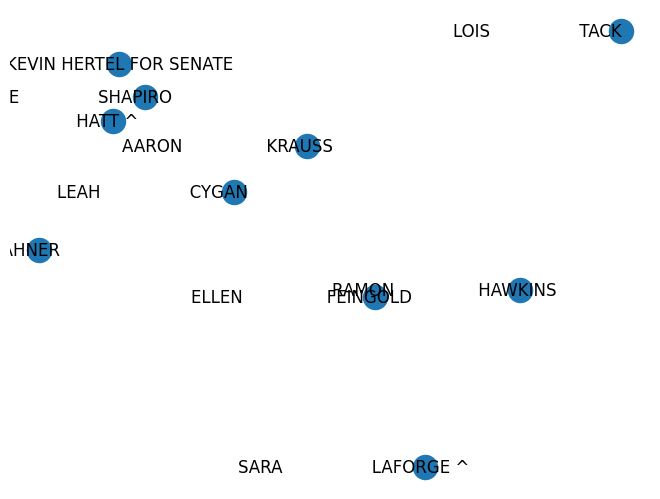

{'id': 'da441d41-1050-4505-a834-99d6023001e1',
 'first_name': 'AARON               ',
 'last_name': 'KRAUSS                              ',
 'full_name': 'AARON                KRAUSS                              ',
 'entity_type': 'Individual',
 'state': 'MI',
 'party': nan,
 'company': nan}

In [105]:
x = add_notes_from_df(inds_sample)
x.nodes['BELA                 LAHNER                              ']

In [104]:
inds_sample.full_name.tolist()

['BELA                 LAHNER                              ',
 'JANICE               SHAPIRO                             ',
 'RAMON                HAWKINS                             ',
 'LEAH                 CYGAN                               ',
 'ALLISON              HATT ^                              ',
 'ELLEN                FEINGOLD                            ',
 'KEVIN HERTEL FOR SENATE',
 'SARA                 LAFORGE ^                           ',
 'LOIS                 TACK                                ',
 'AARON                KRAUSS                              ']

KeyError: 'MALLORY MCMORROW FOR MICHIGAN'

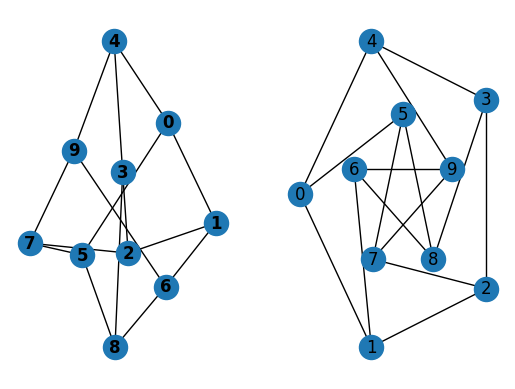

In [5]:
G = nx.petersen_graph()
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='light')


{'REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN PAC': Text(-0.071782758799796, -0.3387166453182715, 'REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN PAC'),
 'Paa Pac': Text(0.06023249378587841, -0.07946204618171311, 'Paa Pac'),
 'UNITED FOOD AND COMMERCIAL WORKERS ACTIVE BALLOT CLUB': Text(-0.12554712442237967, 0.08789304420689323, 'UNITED FOOD AND COMMERCIAL WORKERS ACTIVE BALLOT CLUB'),
 'COMMITTEE TO ELECT DR PATRICIA BERNARD': Text(-0.40486733116122986, -0.04769565353200762, 'COMMITTEE TO ELECT DR PATRICIA BERNARD'),
 'Pabar Pac (Pa Bar Assn)': Text(-0.6714326170558735, 0.21693950702464565, 'Pabar Pac (Pa Bar Assn)'),
 'Ugi Utilities Inc/Ugi Energy Services Llc Pac': Text(1.0, -0.38838038123915186, 'Ugi Utilities Inc/Ugi Energy Services Llc Pac'),
 'Pa Fraternal Order Of Police Pac': Text(0.5897482153166077, -0.2569656851069028, 'Pa Fraternal Order Of Police Pac'),
 'MICHIGAN ASSOCIATION OF NURSE ANESTHETISTS PAC': Text(-0.27784326029554446, 0.2828712220763738, 'MICHIGAN ASSOCIATIO

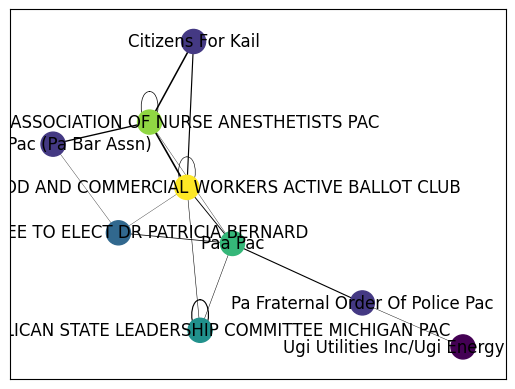

In [11]:
G = nx.from_pandas_edgelist(sample_df,source='name',target='donations_to',edge_attr=['donations','received'])
G.nodes()
pos=nx.spring_layout(G)
weights = list(nx.get_edge_attributes(G,'donations').values())
weights = [i/5000 for i in weights]
node_color = [G.degree(v) for v in G] 
#node_size = [0.0005 * nx.get_node_attributes(G, 'donations')[v] for v in G] 
nx.draw_networkx_nodes(G, pos, node_color=node_color)#, node_size=node_size) 
nx.draw_networkx_edges(G, pos, width=weights)
nx.draw_networkx_labels(G, pos)

In [12]:
G.nodes['Citizens For Kail']

{}

In [8]:

# fixing the size of the figure 
plt.figure(figsize =(10, 7)) 

node_color = [G.degree(v) for v in G] 
# node colour is a list of degrees of nodes 

node_size = [0.0005 * nx.get_node_attributes(G, 'population')[v] for v in G] 
# size of node is a list of population of cities 

edge_width = [0.0015 * G[u][v]['weight'] for u, v in G.edges()] 
# width of edge is a list of weight of edges 

nx.draw_networkx(G, node_size = node_size, 
				node_color = node_color, alpha = 0.7, 
				with_labels = True, width = edge_width, 
				edge_color ='.4', cmap = plt.cm.Blues) 

plt.axis('off') 
plt.tight_layout(); 

KeyError: 'REPUBLICAN STATE LEADERSHIP COMMITTEE MICHIGAN PAC'

<Figure size 1000x700 with 0 Axes>

In [89]:
G = nx.Graph()
G.add_node(0)
nx.set_node_attributes(G, "red", name="color")
nx.set_node_attributes(G, 4, name = 'size')
G.add_node(2)
nx.set_node_attributes(G, "white", name='color')
G.nodes[2]

{'color': 'white'}